In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cftime
from scipy import stats
from sklearn import datasets, model_selection

#### Import tarfile

In [2]:
#import tarfile #"tape archive"

# Specify stored path to .tar file
#tar_file_path = '/Users/C830793391/Documents/Research/member1_bilinear/bilinear.tar'


# Open the .tar file
#with tarfile.open(tar_file_path, 'r') as tar:
    #tar.extractall(path='/Users/C830793391/Documents/Research/member1_bilinear')

Now that the .nc files have been extracted, I am commenting out this block. Not going to keep re-running this line as it keeps getting stuck. (wonder why though?) 

#### What does an .nc file look like...
First instinct is to try peeking at the first few lines of the first .nc file using pandas .head() function

In [43]:
# Specify the path to first .nc file
nc_file_path = '/Users/C830793391/Documents/Research/member1_bilinear/bilinear/v2.LR.historical_0101.eam.h1.1850-01-01-00000.nc'

# Open the .nc file
dataset = xr.open_dataset(nc_file_path, decode_times=True)

# Convert the xarray dataset to a Pandas DataFrame using dataset.to_dataframe()
#dataframe = dataset.to_dataframe()
#print(dataframe.head())

# checking out the various features of xarray dataframes
dataset.coords
dataset.dims
dataset.variables

ValueError: Failed to decode variable 'time': unable to decode time units 'days since 1850-01-01 00:00:00' with "calendar 'noleap'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [38]:
dataset['time']

<xarray.DataArray 'time' (time: 30)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29.])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 25.0 26.0 27.0 28.0 29.0
Attributes:
    long_name:  time
    units:      days since 1850-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bnds

Pandas is is interesting to start understanding this data, however, I see that pandas is limited dimensionally (dim < 3). 

Going to work specifically with Xarray moving forward, as I'm reading that it is more suited to handling higher dimensional data: 

#### Taking a closer look at variables

In [15]:
variables = list(dataset.data_vars.keys())  # Discover what variables exist in the data by accessing the data_vars keys
print(variables)

['lat_bnds', 'lon_bnds', 'gw', 'area', 'PRECT', 'TS', 'U050', 'U100', 'U250', 'U850', 'Z500', 'time_bnds']


In [16]:
# Variables of the dataset are keys in a dictionary of keys (variables) and their values (attributes about the variables)
# The xarray attributes are housed in a nested dictionary. I want to see the 'long name' for each variable's values:

dataset['TS'].attrs['long_name'] # this is just one instance, how do I extract all the 'long-name' values from all variables at once?

specific_key = 'long_name'

for variable_name in dataset.variables:     # variable_name are the variables, dataset.variables contains the variables
    variable = dataset[variable_name]       # collecting all the variables from the dataset
    if specific_key in variable.attrs:      # if 'long_name' is present in the attributes of each iterated variable, call and print the variable and its corresponding attribute
        print(f"{variable_name} : {variable.attrs[specific_key]}")


lat : Latitude of Grid Cell Centers
lon : Longitude of Grid Cell Centers
lat_bnds : Gridcell latitude interfaces
lon_bnds : Gridcell longitude interfaces
gw : Latitude quadrature weights (normalized to sum to 2.0 on global grids)
area : Solid angle subtended by gridcell
PRECT : Total (convective and large-scale) precipitation rate (liq + ice)
TS : Surface temperature (radiative)
U050 : Zonal wind at 50 mbar pressure surface
U100 : Zonal wind at 100 mbar pressure surface
U250 : Zonal wind at 250 mbar pressure surface
U850 : Zonal wind at 850 mbar pressure surface
Z500 : Geopotential Z at 500 mbar pressure surface
time : time
time_bnds : time interval endpoints


### Visualizing Surface Temperature

Text(0.5, 0, 'longtitude [deg east]')

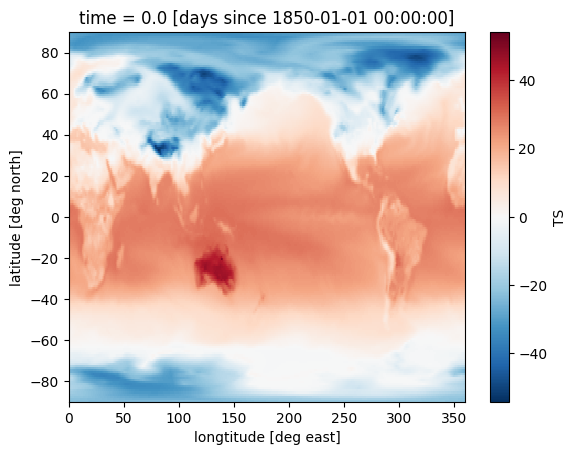

In [17]:
# dataset.TS.plot() # looks like it creates a histogram of temperatures

surf_temp = dataset.TS - 273.15 # convert temp to celsius
surf_temp2d = surf_temp.isel(time = 0)  # select the first time element (day) and plot the temp given lat long on that day using .isel (is element?)
surf_temp2d.plot()
plt.ylabel("latitude [deg north]")
plt.xlabel("longtitude [deg east]")
#plt.title("Surface temperature (radiative) at Time = 0) - how to incorporate the time into a more specific title without hardcoding? 


### 3D Map?

Found this librariy in the xarray documentation, curious to see if this data can be plotted on a globe:

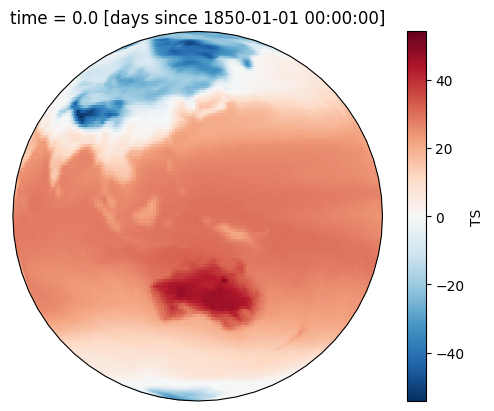

In [19]:
import cartopy.crs as ccrs

cart_plot = surf_temp.isel(time = 0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(130, 0), facecolor="gray"),transform=ccrs.PlateCarree(),
)

I adjusted the plot to highlight the particularly high temperatures in Austrialia at T0. 

This visualization may not be as helpful as a 2d representation since less data is visible in one glance, still fun to play with though!

### Lets play with windspeed ###

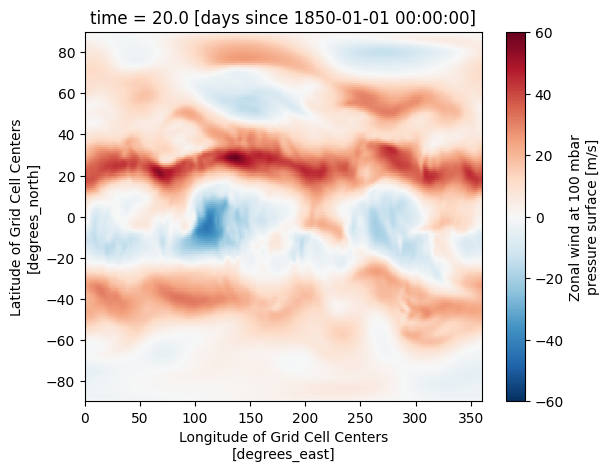

In [20]:
U100 = dataset.U100
U100.plot()     # Histogram
U100_2D = U100.isel(time = 20) 
U100_2D.plot()

### Let's bring in other .nc files 

Compare summer and winter temperatures

In [23]:
nc_file_path = '/Users/C830793391/Documents/Research/member1_bilinear/bilinear/v2.LR.historical_0101.eam.h1.1850-07-30-00000.nc'

# Open the .nc file
dataset_1850_07_30 = xr.open_dataset(nc_file_path, decode_times=False)

Text(0.5, 0, 'longtitude [deg east]')

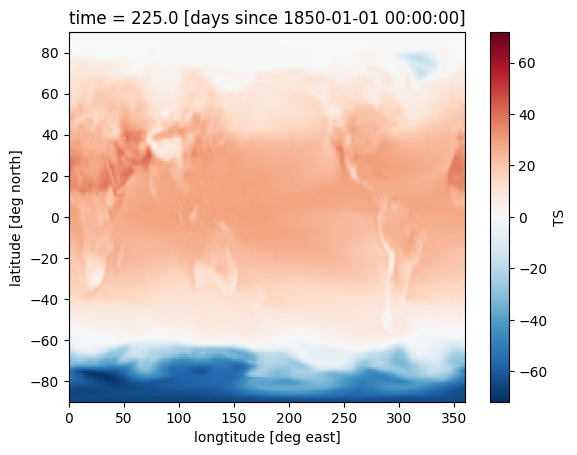

In [24]:
surf_temp_summer = dataset_1850_07_30.TS - 273.15
surf_temp_summer2d = surf_temp_summer.isel(time = 15)
surf_temp_summer2d.plot()
plt.ylabel("latitude [deg north]")
plt.xlabel("longtitude [deg east]")

Qualitatively the maps indicate that the summertime northern hemisphere has higher temperatures than the wintertime northern hemisphere, but let's quantify this:

In [25]:
foco_lat = round(40.5853)
foco_lon = round(105.0844)

summer_days = []
for day in dataset_1850_07_30.time:
    # Extract surface temperature for the specified location (foco_lat, foco_lon)
    temp_at_location = float(dataset_1850_07_30.TS.sel(time=day, lat=foco_lat, lon=foco_lon, method = 'nearest') - 273.15)
    
    # Append the temperature to the list
    summer_days.append(temp_at_location)

# Now, summer_days contains the daily temperatures for the specified location
print(summer_days)


winter_days = []
for day in dataset.time:
    temp_at_location2 = float(dataset.TS.sel(time =day, lat = foco_lat, lon = foco_lon, method = 'nearest') - 273.15)
    winter_days.append(temp_at_location2)

print(winter_days)

[21.611505126953148, 25.918054199218773, 27.269952392578148, 28.610772705078148, 28.528924560546898, 27.382684326171898, 25.381677246093773, 23.286889648437523, 20.779382324218773, 22.717462158203148, 24.222894287109398, 25.480096435546898, 26.536431884765648, 26.904138183593773, 28.382836914062523, 28.236138916015648, 26.099847412109398, 18.609643554687523, 21.621148681640648, 22.120141601562523, 23.972375488281273, 25.692590332031273, 24.254602050781273, 23.169976806640648, 21.436029052734398, 23.083612060546898, 22.313195800781273, 19.446862792968773, 23.126092529296898, 24.119531250000023]
[-20.995443725585915, -16.813330078124977, -17.005468749999977, -15.552069091796852, -17.82573547363279, -17.002874755859352, -18.72484436035154, -18.370733642578102, -16.119573974609352, -14.711248779296852, -14.854589843749977, -11.903570556640602, -13.699682617187477, -11.639349365234352, -14.486639404296852, -17.233648681640602, -17.128790283203102, -14.141851806640602, -8.564367675781227, -7